In [1]:
import pandas as pd
import os

DATA_DIR = "/kaggle/input/vqa-rad-visual-question-answering-radiology"

In [2]:
data = pd.read_excel(DATA_DIR+"/VQA_RAD Dataset Public.xlsx")

/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
data.head()

,QID_unique,QID_para,QID_linked,IMAGEID_case,IMAGEID,IMAGEORGAN,EVALUATION,QUESTION,Q_REPHASE,Q_RELATION,Q_FRAMED,Q_TYPE,ANSWER,A_TYPE
0,0,freeform,03f451ca-de62-4617-9679-e836026a7642,https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...,https://medpix.nlm.nih.gov/images/full/synpic5...,HEAD,not evaluated,Are regions of the brain infarcted?,NaN,NaN,NaN,PRES,Yes,CLOSED
1,1,freeform,06e26b2c-04b9-42bc-8e98-1de30a0f7682,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Are the lungs normal appearing?,NaN,NaN,NaN,ABN,No,CLOSED
2,2,freeform,0d0e8b6b-7753-4788-9b6d-dc7f25250c3f,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Is there evidence of a pneumothorax,NaN,NaN,NaN,PRES,No,CLOSED
3,3,freeform,0e90b6bc-265f-490b-a039-509b9907a3cb,https://medpix.nlm.nih.gov/case?id=19aa8a2b-35...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,given,What type of imaging does this not represent?,NaN,NaN,NaN,MODALITY,ultrasound,OPEN
4,4,freeform,1179f612-12e0-4dda-aee0-f14a5200be7b,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,given,Is this a MRI of the chest?,NaN,NaN,NaN,MODALITY,no,CLOSED


In [4]:
# Function to extract filename and append to parent dir

def extract_filename_and_append(row, parent_dir):
    filename = os.path.basename(row['IMAGEID'])
    return os.path.join(parent_dir, filename)

data['img_path'] = data.apply(extract_filename_and_append, parent_dir=DATA_DIR+"/VQA_RAD Image Folder/VQA_RAD Image Folder", axis=1)

In [5]:
data["img_path"][0]

'/kaggle/input/vqa-rad-visual-question-answering-radiology/VQA_RAD Image Folder/VQA_RAD Image Folder/synpic54610.jpg'

In [6]:
data['cleaned_question'] = data['QUESTION'].str.replace("?", "").str.lower()
data['labels'] = data['ANSWER'].str.lower()

In [7]:
data['labels'].value_counts()

labels
no                        606
yes                       587
axial                      43
right                      26
left                       19
                         ... 
vasculature                 1
mri diffusion weighted      1
infarcts                    1
embolus                     1
irregular                   1
Name: count, Length: 512, dtype: int64

In [8]:
data.shape

(2248, 17)

In [9]:
# Identify classes with less than 200 samples
classes_to_augment = data['labels'].value_counts()[data['labels'].value_counts() < 200]
print(classes_to_augment)

labels
axial                     43
right                     26
left                      19
pa                        15
ct                        13
                          ..
vasculature                1
mri diffusion weighted     1
infarcts                   1
embolus                    1
irregular                  1
Name: count, Length: 510, dtype: int64


# torch vae

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch, dim = z_mean.size()
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 4 * 4, 256)  # Corrected for 4x4 spatial size at the bottleneck
        self.fc_mean = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)  # Adjusted to match encoder output
        self.conv_transpose1 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.conv_transpose3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv_transpose4 = nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 4, 4)  # Correct view for the decoder input
        x = F.relu(self.conv_transpose1(x))
        x = F.relu(self.conv_transpose2(x))
        x = F.relu(self.conv_transpose3(x))
        x = torch.sigmoid(self.conv_transpose4(x))  # Use sigmoid for final layer to bound the output
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        z = self.encoder.sampling(z_mean, z_log_var)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

def vae_loss(reconstruction, x, z_mean, z_log_var):
    reconstruction_loss = F.mse_loss(reconstruction, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return reconstruction_loss + kl_loss

In [12]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CustomDataset(data['img_path'].tolist(), transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and optimizer
latent_dim = 128  # Define latent dimension size
vae = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training parameters
epochs = 50  # Number of epochs to train for

# Lists to store losses for plotting or analysis
epoch_losses = []

# Training loop
for epoch in range(epochs):
    epoch_loss = 0  # Reset epoch loss at the start of each epoch
    vae.train()  # Set model to training mode
    
    with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch + 1}/{epochs}") as batch_bar:
        for batch_idx, images in batch_bar:
            images = images.to(device)
            optimizer.zero_grad()

            # Forward pass through VAE
            reconstruction, z_mean, z_log_var = vae(images)
            loss = vae_loss(reconstruction, images, z_mean, z_log_var)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

            # Update the progress bar
            batch_bar.set_postfix(loss=f"{loss.item():.4f}", epoch_loss=f"{epoch_loss/(batch_idx+1):.4f}")

    # Append the average loss for the current epoch
    epoch_losses.append(epoch_loss / len(dataloader))

In [ ]:
# model_save_path = 'vae_model.pth'
# torch.save(vae.state_dict(), model_save_path)

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def generate_and_plot_image(image_path, vae_model):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move to the same device as model
    image_tensor = image_tensor.to(next(vae_model.parameters()).device)
    
    # Generate the image
    with torch.no_grad():
        reconstructed, _, _ = vae_model(image_tensor)
    
    # Denormalize the images
    def denormalize(tensors):
        return tensors * 0.5 + 0.5

    # Convert tensors to numpy arrays for plotting
    original = denormalize(image_tensor.squeeze()).permute(1, 2, 0).cpu().numpy()
    generated = denormalize(reconstructed.squeeze()).permute(1, 2, 0).cpu().numpy()

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(generated)
    axes[1].set_title('Generated Image')
    axes[1].axis('off')

    plt.show()

# Example usage:
# Assuming `vae` is your trained VAE model and `image_path` is the path to your input image
generate_and_plot_image(data["img_path"][1], vae)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def generate_and_plot_image(image_path, vae_model):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move to the same device as model
    image_tensor = image_tensor.to(next(vae_model.parameters()).device)
    
    # Generate the image
    with torch.no_grad():
        reconstructed, _, _ = vae_model(image_tensor)
    
    # Denormalize the images
    def denormalize(tensors):
        return tensors * 0.5 + 0.5

    # Convert tensors to numpy arrays for plotting
    original = denormalize(image_tensor.squeeze()).permute(1, 2, 0).cpu().numpy()
    generated = denormalize(reconstructed.squeeze()).permute(1, 2, 0).cpu().numpy()

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(generated)
    axes[1].set_title('Generated Image')
    axes[1].axis('off')

    plt.show()

# Example usage:
# Assuming `vae` is your trained VAE model and `image_path` is the path to your input image
generate_and_plot_image(data["img_path"][700], vae)

# Loss Plot

# Vanilla vae

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import List
from torch import Tensor

class VanillaVAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [17]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CustomDataset(data['img_path'].tolist(), transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [18]:
model_params = {
    "in_channels": 3,
    "latent_dim": 128,
    "train_batch_size": 64,
    "LR": 0.0005,
    "weight_decay": 0.0,
    "scheduler_gamma": 0.95,
    "kld_weight": 0.00025,   
    "max_epochs": 100
}

In [ ]:
from torch import optim
from tqdm import tqdm

# Initialize the model
vae = VanillaVAE(in_channels=model_params["in_channels"], 
                 latent_dim=model_params["latent_dim"])

# Assuming the device is set appropriately
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

# Optimizer and Scheduler
optimizer = optim.Adam(vae.parameters(), lr=model_params["LR"], weight_decay=model_params["weight_decay"])
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=model_params["scheduler_gamma"])

# Lists to store losses for plotting
plot_loss = []
plot_rloss = []
plot_kldloss = []

# Training loop
for epoch in range(model_params['max_epochs']):
    vae.train()
    epoch_loss = 0
    epoch_rloss = 0
    epoch_kldloss = 0
    with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{model_params['max_epochs']}") as batch_bar:
        for batch_idx, images in batch_bar:
            images = images.to(device)
            optimizer.zero_grad()

            # Forward pass
            recons, _, mu, log_var = vae(images)
            train_loss = vae.loss_function(recons, images, mu, log_var, M_N=model_params['kld_weight'])

            # Backward pass and optimize
            train_loss['loss'].backward()
            optimizer.step()
            
            epoch_loss += train_loss['loss'].item()
            epoch_rloss += train_loss['Reconstruction_Loss'].item()
            epoch_kldloss += train_loss['KLD'].item()
            
            # Update the progress bar
            batch_bar.set_postfix(loss=f"{train_loss['loss'].item():.4f}", 
                                  epoch_loss=f"{epoch_loss/(batch_idx+1):.4f}",
                                  recon_loss=f"{epoch_rloss/(batch_idx+1):.4f}",
                                  kld_loss=f"{epoch_kldloss/(batch_idx+1):.4f}")
        
        # Append the average losses for the epoch
        plot_loss.append(epoch_loss / len(dataloader))
        plot_rloss.append(epoch_rloss / len(dataloader))
        plot_kldloss.append(epoch_kldloss / len(dataloader))

    scheduler.step()

In [ ]:
model_save_path = 'vae_model.pth'
torch.save(vae.state_dict(), model_save_path)

In [19]:
vae = VanillaVAE(in_channels=model_params["in_channels"], 
                 latent_dim=model_params["latent_dim"])

vae.load_state_dict(torch.load('/kaggle/input/vae_model/pytorch/1/1/vae_model.pth'))

<All keys matched successfully>

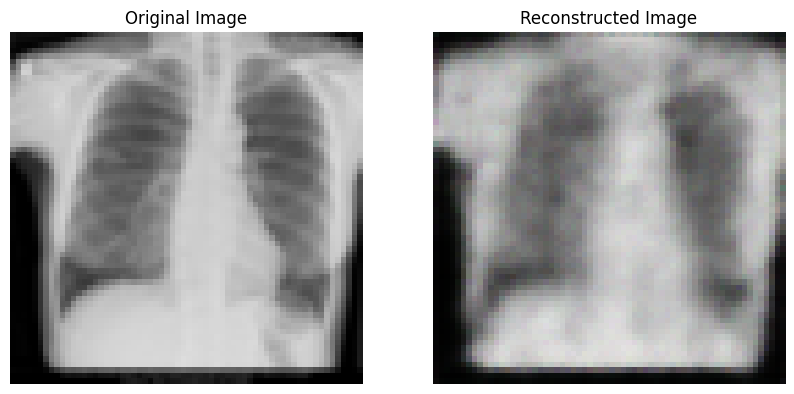

In [110]:
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def denormalize(tensor):
    # Assuming the same normalization was applied (mean=0.5, std=0.5 for each channel)
    return tensor * 0.5 + 0.5

def generate_and_plot_image(image_path, model):
    # Ensure model is in evaluation mode
    model.eval()
    
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move tensor to the same device as the model
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)
    
    # Generate reconstructed image
    with torch.no_grad():
        reconstructed, _, _, _ = model(image_tensor)
    
    # Move tensors back to CPU for plotting
    image_tensor = image_tensor.to('cpu')
    reconstructed = reconstructed.to('cpu')
    
    # Denormalize images
    original_img = denormalize(image_tensor.squeeze()).permute(1, 2, 0).numpy()
    reconstructed_img = denormalize(reconstructed.squeeze()).permute(1, 2, 0).numpy()
    
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(reconstructed_img)
    axs[1].set_title('Reconstructed Image')
    axs[1].axis('off')
#     plt.savefig('original_and_reconstructed.png', bbox_inches='tight')
    plt.show()
    
    plt.imsave("original_img.png", original_img)
    plt.imsave("reconstructed_img.png", reconstructed_img)
#     plt.savefig("aug.png")

# Example usage:
# Assuming `vae` is your trained VAE model and `image_path` is the path to your input image
generate_and_plot_image(data["img_path"][1247], vae)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def denormalize(tensor):
    # Assuming the same normalization was applied (mean=0.5, std=0.5 for each channel)
    return tensor * 0.5 + 0.5

def generate_and_plot_image(image_path, model):
    # Ensure model is in evaluation mode
    model.eval()
    
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move tensor to the same device as the model
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)
    
    # Generate reconstructed image
    with torch.no_grad():
        reconstructed, _, _, _ = model(image_tensor)
    
    # Move tensors back to CPU for plotting
    image_tensor = image_tensor.to('cpu')
    reconstructed = reconstructed.to('cpu')
    
    # Denormalize images
    original_img = denormalize(image_tensor.squeeze()).permute(1, 2, 0).numpy()
    reconstructed_img = denormalize(reconstructed.squeeze()).permute(1, 2, 0).numpy()
    
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(reconstructed_img)
    axs[1].set_title('Reconstructed Image')
    axs[1].axis('off')
    
    plt.show()

# Example usage:
# Assuming `vae` is your trained VAE model and `image_path` is the path to your input image
generate_and_plot_image(data["img_path"][600], vae)

In [ ]:
print(plot_loss)
print(plot_rloss)
print(plot_kldloss)

In [ ]:
import matplotlib.pyplot as plt

# Assuming plot_loss, plot_rloss, and plot_kldloss are lists containing the loss values for each epoch

plt.figure(figsize=(10, 6))
plt.plot(plot_loss, label='Total Loss')
plt.title('VAE Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(plot_rloss, label='Reconstruction Loss', linestyle='--')
plt.plot(plot_kldloss, label='KL Divergence Loss', linestyle='-.')
plt.title('VAE Reconstruction and KL Divergence Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(plot_rloss, label='Reconstruction Loss')
# plt.plot(plot_kldloss, label='KL Divergence Loss', linestyle='-.')
plt.title('VAE Reconstruction Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
# plt.plot(plot_rloss, label='Reconstruction Loss', linestyle='--')
plt.plot(plot_kldloss, label='KL Divergence Loss', color='orange')
plt.title('VAE KL Divergence Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ResNet-VAE

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torch.autograd import Variable
from tqdm import tqdm
from torchvision import models

class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.relu(self.fc_bn4(self.fc4(z)))
        x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
#     MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256     # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability


# training parameters
epochs = 100        # training epochs
batch_size = 64
learning_rate = 1e-4

class CustomDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CustomDataset(data['img_path'].tolist(), transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Initialize the model
model = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with tqdm
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}") as batch_bar:
        for batch_idx, images in batch_bar:
            images = images.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            recon_images, z, mu, logvar = model(images)
            loss = loss_function(recon_images, images, mu, logvar)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()35
            
            # Update tqdm progress bar
            batch_bar.set_postfix(loss=f"{loss.item():.4f}", epoch_loss=f"{epoch_loss/(batch_idx + 1):.4f}")

In [ ]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

def denormalize(tensor):
    """
    Denormalizes a tensor from the range [-1, 1] back to [0, 1]
    """
    return tensor * 0.5 + 0.5

def generate_and_plot_image(image_path, model):
    """
    Generates a reconstructed image using the provided VAE model and plots
    it alongside the original image.
    """
    model.eval()  # Set the model to evaluation mode
    
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
    
    # Move the tensor to the same device as the model
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)
    
    # Generate the reconstructed image
    with torch.no_grad():
        reconstructed, _, _, _ = model(image_tensor)
    
    # Move tensors back to CPU for plotting
    image_tensor = image_tensor.cpu()
    reconstructed = reconstructed.cpu()
    
    # Denormalize the images for display
    original_img = denormalize(image_tensor.squeeze()).permute(1, 2, 0).numpy()
    reconstructed_img = denormalize(reconstructed.squeeze()).permute(1, 2, 0).numpy()
    
    # Plotting the original and reconstructed images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(reconstructed_img)
    axs[1].set_title('Reconstructed Image')
    axs[1].axis('off')
    
    plt.show()

# Example usage
# Ensure 'vae' is your trained ResNet_VAE model and 'image_path' is a valid image file path
generate_and_plot_image(data["img_path"][0], model)  # Replace 'vae' with your model variable